

# Automated Curriculum Learning for Neural Networks

An implementation of the "Automated Curriculum Learning for Neural Networks" paper by Graves et. al

Code: Jayson Salkey
Date: 15/06/2018

### LSTM Model settings:
Number of Hidden Units for Dense Layers: 64

LSTM Units: 32

Learning Rate: 0.01

Optimiser: AdamOptimiser

Activation: ReLu

Initialiser: Xavier Initialisation

# Setup

### Import Useful Libraries

In [80]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [81]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
%matplotlib inline  

### A generic multi-armed bandit class, with Bernoulli rewards

In [82]:
class BernoulliBandit(object):
  
  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.
    Args:
      action: An integer or tf.int32 that specifies which arm to pull.
    Returns:
      A sampled reward according to the success probability of the selected arm.
    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [83]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))
  
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      ax.set_axis_bgcolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
        except:
            raise ValueError(
              "The step function of algorithm `{}` failed.\
              Perhaps you have a bug, such as a typo.\
              Or, perhaps your value estimates or policy has diverged.\
              (E.g., internal quantities may have become NaNs.)\
              Try adding print statements to see if you can find a bug.".format(alg.name))
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        
  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_experiment(bandit, agents, repetitions)
  
  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]

  plot(agents, plot_data, optimal_value)

## Agent 0: Random

In [84]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)
  
  def getProbs(self):
    return np.ones((self._number_of_arms))/self._number_of_arms
  
  def reset(self):
    pass


## Agent 1: greedy


In [85]:
class Greedy(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.action_values = np.zeros((2,number_of_arms))
    self.reset()
    return
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
#     unvisited = np.where(self.action_values[1,:] == 0.)
#     return unvisited[0][0] if unvisited[0].size > 0 else np.argmax(
#         np.divide(self.action_values[0,:],self.action_values[1,:]))
    
    #On the condition where Q values are equivalent, randomly select one of them
    Q = np.where(self.action_values[1,:] != 0, self.action_values[0,:]/self.action_values[1,:], 0)
    M = np.amax(Q)
    return np.random.choice(np.where(Q == M)[0])
    
  def getProbs(self):
    # Not really probs
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2,number_of_arms))
    return


## Agent 2: $\epsilon$-greedy



In [86]:
class EpsilonGreedy(object):

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = 'epsilon-greedy epsilon:{}'.format(epsilon)
    self.action_values = np.zeros((2,number_of_arms))
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
#     unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       if np.random.random() < 1-self._epsilon:
#         return np.argmax(np.divide(self.action_values[0,:],self.action_values[1,:]))
#       else:
#         return np.random.randint(self._number_of_arms)

    if np.random.random() < 1-self._epsilon:
      #On the condition where Q values are equivalent, randomly select one of them
      Q = np.where(self.action_values[1,:] != 0, self.action_values[0,:]/self.action_values[1,:], 0)
      M = np.amax(Q)
      return np.random.choice(np.where(Q == M)[0])
    return np.random.randint(self._number_of_arms)

  def getProbs(self):
    # Not really probs
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2,number_of_arms))
    return


## Agent 3: UCB


In [87]:
class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.action_values = np.zeros((2,number_of_arms))
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else np.argmax(
        np.sqrt(np.log(self.time)/self.action_values[1,:]) + np.divide(self.action_values[0,:],self.action_values[1,:]))
  
  def getProbs(self):
    # Not really probs
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2,number_of_arms))
    self.time = 0
    return


## Agent 4: REINFORCE agents
Implementation of REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.


In [88]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.action_values = np.zeros((2,number_of_arms))
    self.action_preferences = np.zeros((1,number_of_arms))
    self.total_reward = 0;
    self.number_rewards = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.number_rewards += 1.
      self.total_reward += reward
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
      self.updatePreferences(previous_action, reward)
#    unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
  def reset(self):
    self.action_values = np.zeros((2,number_of_arms))
    self.action_preferences = np.zeros((1,number_of_arms))
    self.number_rewards = 0.
    self.total_reward = 0.
  
  def updatePreferences(self, previous_action, reward):
    if not self._baseline: 
      self.action_preferences[0,previous_action]+=self._lr*reward*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*reward*self.softmax()[i]
    else:
      self.action_preferences[0,previous_action]+=self._lr*(reward - self.total_reward/self.number_rewards)*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*(reward - self.total_reward/self.number_rewards)*self.softmax()[i]
    
  def softmax(self):
    q = np.sum(np.exp(self.action_preferences),axis=1)
    t = np.exp(self.action_preferences)/q
    return t.flatten()
  
  def getProbs(self):
    return self.softmax()
  
  
      


## Agent 5: EXP3

In [89]:
class EXP3(object):

  def __init__(self, number_of_arms, gamma):
    self._number_of_arms = number_of_arms
    self.name = 'exp3 Gamma: ' + str(gamma)
    
    self.action_values = np.zeros((2,number_of_arms))
    
    self.gamma = gamma
    self.weights = np.ones((1,number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 6: EXP3.S

In [90]:
class EXP3S(object):

  def __init__(self, number_of_arms, gamma, alpha):
    self._number_of_arms = number_of_arms
    self.name = 'exp3s Gamma: ' + str(gamma) + ', Alpha: ' + str(alpha) 
    
    self.action_values = np.zeros((2,number_of_arms))
    
    self.gamma = gamma
    self.alpha = alpha
    self.weights = np.ones((1,number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      # Should the added term be using updated weights as we move across arms, or simultaenous updates?
      #print 'test'
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms) + ((np.e*self.alpha)/(self._number_of_arms))*np.sum(self.weights)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 7: EXP4

### Sanity Check 1

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

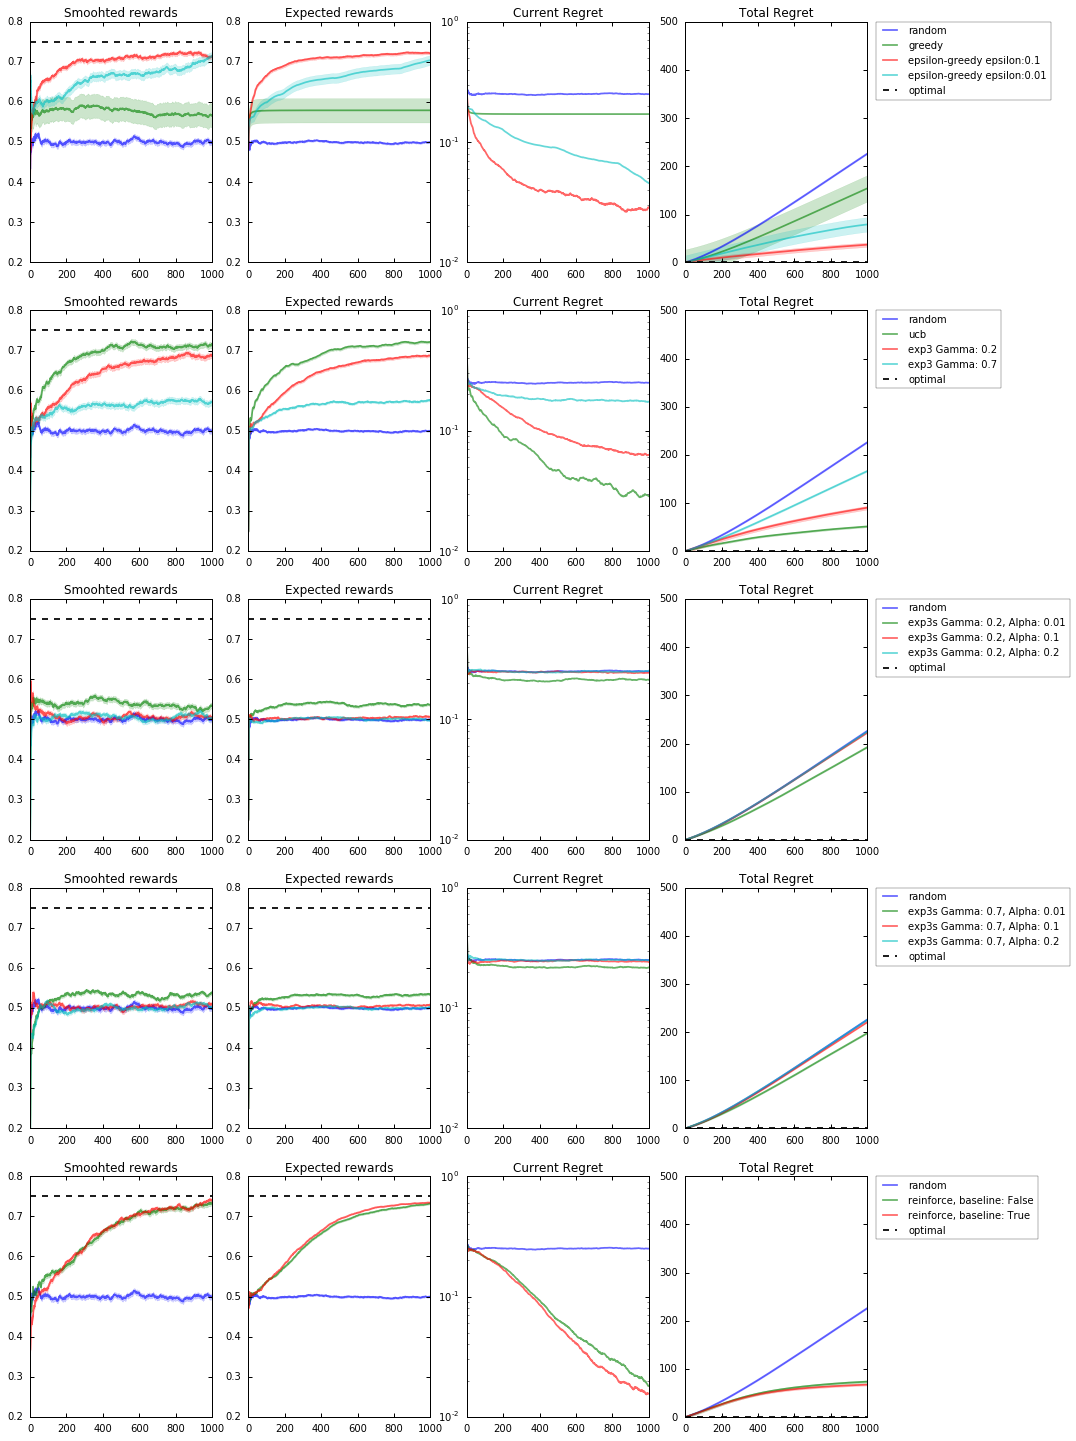

In [91]:
#@title Experiment 1: Bernoulli bandit

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    EXP3(number_of_arms, 0.2),
    EXP3(number_of_arms, 0.7),
    EXP3S(number_of_arms, 0.2, 0.01),
    EXP3S(number_of_arms, 0.2, 0.1),
    EXP3S(number_of_arms, 0.2, 0.2),
    EXP3S(number_of_arms, 0.7, 0.01),
    EXP3S(number_of_arms, 0.7, 0.1),
    EXP3S(number_of_arms, 0.7, 0.2),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

### Sanity Check 2

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

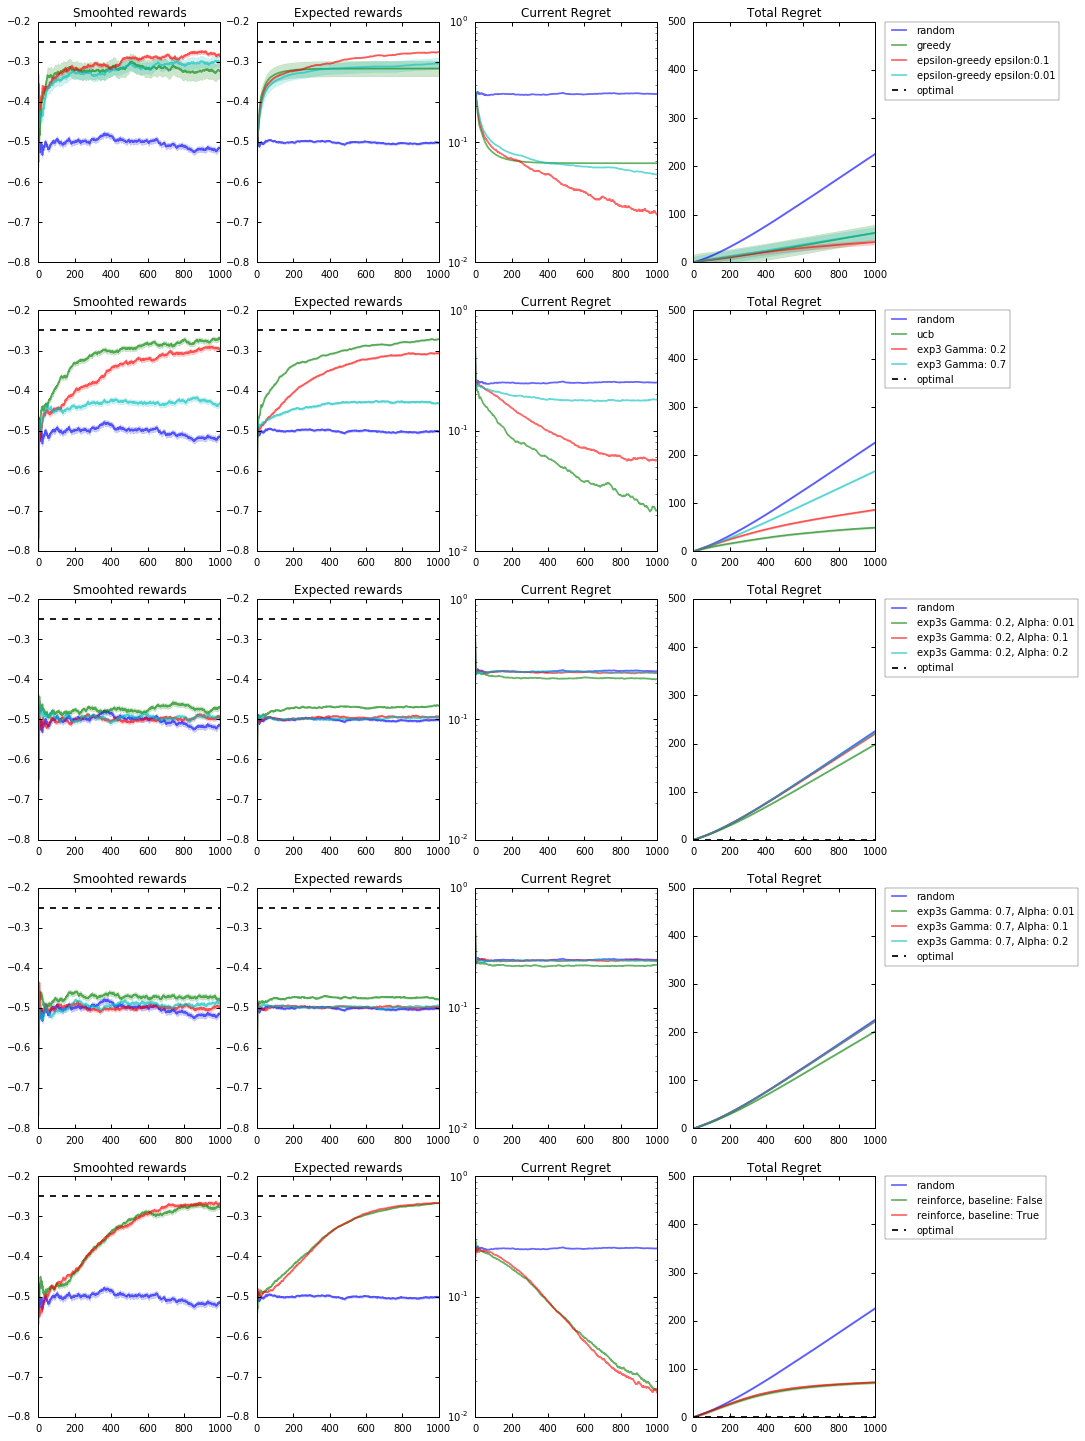

In [92]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

### Task Description

Consider the following generative model: 
* We have $3$ symbols that will be generates from a multinomial/categorical distribution, with parameters $\textbf{p}=(p_1, p_2, p_3)$: symbol 1 is generated with probability $p_1$, symbol 2 is generated with probability $p_2$, symbol 3 with probability $p_3$. 
$$X \sim Categorical(3, \textbf{p})$$

* The parameter vector $\textbf{p}$ is drawn from a Dirichlet prior: $$\textbf{p} \sim Dirichlet(\alpha)$$

We are going to use the above to generate sequences (a continuous stream of data/observations), in the following way:
* Step 1: We sample $\textbf{p}$ from the prior
* Step 2: Given this $\textbf{p}$, for $T-1$ time-steps we will generate i.i.d observations by sampling one of the $3$ symbols from the categorical distribution induced by $\textbf{p}$
$$ (X_1, X_2, \cdots X_{T-1}) , s.t. X_i \sim Categorical(3, \textbf{p})$$
* Step 3: At the end of the sequence we append a fourth symbol (RESET): $(X_1, X_2, \cdots X_T, RESET)$
* Step 4: Return to Step 1 and resample $\textbf{p}$. 
* Repeat this 'forever'.

This will give rise to a continuous stream of data, of the form: $ x_1, x_2, \cdots x_{T-1}, RESET, x_{T+1}, x_{T+2}, \cdots x_{2T}, RESET, \cdots, x_{kT+1}, x_{kT+2}, \cdots x_{(k+1)T}, RESET, \cdots$.

Note: Data generation is provided for you in the cell below. (You just need to call the minibatch function to get a sequence of this form).

### Model

We are going to consider an simple LSTM (32 units hidden state) and present this (generated) sequence of data as an input. Similar to the pixel-to-pixel model, at each time step the LSTM will receive one bit of information (gets to observe the symbol recorded at this time step) and need to output the probability distribution for the next symbol. Thus, at time $t$ the LSTM get as input the symbol $x_t$ and will return a probability over the next state $P(x_{t+1}| x_{t}, LSTM_{t-1})$.



In [93]:
#@title Generate data function

n_symbols = 3
def get_data_per_task(number_samples_per_task=10, p=None, alpha=None):
  if p == None:
    # sample task
    if alpha == None:
      p = np.random.dirichlet((1.3, 1.3, 1.3), 1)[0]
    else:
      p = np.random.dirichlet(alpha, 1)[0]
    
  p = np.append(p, [0])
  sample = np.random.multinomial(1, p, size = number_samples_per_task)
  
  sample = np.append(sample,[[0,0,0,1]], axis=0)
  return sample
  

def get_data(ntasks, nsamples_per_task, p=None, alpha=None):
  sample = []
  for task_id in range(ntasks):
    sample.append(get_data_per_task(number_samples_per_task = nsamples_per_task, p=p, alpha=alpha))
  return np.concatenate(sample)


def get_minibatch(batch_size, ntasks, nsamples_per_task, p=None, alpha=None):
  sample = get_data(batch_size*ntasks, nsamples_per_task, p=p, alpha=alpha)
  return np.reshape(sample, [batch_size, ntasks*(nsamples_per_task+1), n_symbols+1])
  

In [94]:
# #@title Your models

# num_epochs=5
# learning_rate=0.001
# batch_size=32
# fully_connected_hidden_units=64
# size = 32

# experiment_settings = [(5,(10.,1.,1.)),(20,(10.,1.,1.)),(5,(1.3,1.3,1.3)),(20,(1.3,1.3,1.3))]
  
# # Advisable to you GPU for this part
# #with tf.device('/device:GPU:*'):

# tf.reset_default_graph()
# x = tf.placeholder(tf.float64, [None, None, 4])

# #####################################################
# # Define model, loss, update and evaluation metric. #
# #####################################################

# initializer = tf.contrib.layers.xavier_initializer()

# cell = tf.contrib.rnn.BasicLSTMCell(size, activation=tf.nn.relu)

# outputs, state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float64)

# print outputs.shape
# outputs = tf.reshape(outputs, [-1, outputs.shape[2]])

# h1 = tf.layers.dense(outputs,fully_connected_hidden_units,
#                      activation=tf.nn.relu,
#                      bias_initializer=initializer,
#                      kernel_initializer=initializer)

# y = tf.layers.dense(h1,4,activation=None,
#                      bias_initializer=initializer,
#                      kernel_initializer=initializer)

# yr = tf.reshape(y, tf.shape(x))

# y_truth = tf.placeholder(tf.float64, [None, None, 4])


# print tf.shape(yr), yr.shape
# print tf.shape(y_truth), y_truth.shape

# xEnt = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_truth, 
#                                                             logits=yr))

# adam_opt = tf.train.AdamOptimizer(learning_rate).minimize(xEnt)

# prediction = tf.nn.softmax(yr)

# correct_prediction = tf.equal(tf.contrib.distributions.Bernoulli(probs=prediction,dtype=tf.float64).sample(), (y_truth))
# acc = tf.reduce_mean(tf.cast(correct_prediction,tf.float64))


In [102]:
setting = (20,(10,1.3,1.3))
train_images_size_dataset = 10000
ntasks = 200/setting[0]
samples_per_task = setting[0]

# Train.

print 'Setting: ', setting

test_images = get_minibatch(50, ntasks, samples_per_task, alpha=setting[1])
train_images = get_minibatch(train_images_size_dataset, ntasks, samples_per_task, alpha=setting[1])

print test_images.shape, 'Test set Shape'
print train_images.shape, 'Training set Shape'

split_test_tasks = np.split(test_images, ntasks, axis=1)
split_train_tasks = np.split(train_images, ntasks, axis=1)

print split_train_tasks[0].shape, 'Task Shape'


Setting:  (20, (10, 1.3, 1.3))
(50, 210, 4) Test set Shape
(10000, 210, 4) Training set Shape
(10000, 21, 4) Task Shape


In [106]:
class TaskBandit(object):
  """An adversarial multi-armed Task bandit."""
  
  
  def __init__(self, number_of_fcu_hidden, number_of_rnn_cells, reward_signal, learning_rate=0.001):
    tf.reset_default_graph()
    self._number_of_fcu_hidden = number_of_fcu_hidden
    self._number_of_rnn_cells = number_of_rnn_cells
    self._learning_rate = learning_rate
    self._unscaled_reward_history = []
    self._reward_signal = reward_signal
    self.handleTFGraph()
    
  def handleTFGraph(self):
    self._sess = tf.Session()
    
    self._x = tf.placeholder(tf.float64, [None, None, 4])

    #####################################################
    # Define model, loss, update and evaluation metric. #
    #####################################################

    self._initializer = tf.contrib.layers.xavier_initializer()

    self._cell = tf.contrib.rnn.BasicLSTMCell(self._number_of_rnn_cells, activation=tf.nn.relu)

    self._outputs, self._state = tf.nn.dynamic_rnn(self._cell, self._x, dtype=tf.float64)

    print self._outputs.shape
    self._outputs = tf.reshape(self._outputs, [-1, self._outputs.shape[2]])

    self._h1 = tf.layers.dense(self._outputs,self._number_of_fcu_hidden,
                         activation=tf.nn.relu,
                         bias_initializer=self._initializer,
                         kernel_initializer=self._initializer)

    self._y = tf.layers.dense(self._h1,4,activation=None,
                         bias_initializer=self._initializer,
                         kernel_initializer=self._initializer)

    self._yr = tf.reshape(self._y, tf.shape(self._x))

    self._y_truth = tf.placeholder(tf.float64, [None, None, 4])


    print tf.shape(self._yr), self._yr.shape
    print tf.shape(self._y_truth), self._y_truth.shape

    self._xEnt = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self._y_truth, 
                                                                logits=self._yr))

    self._adam_opt = tf.train.AdamOptimizer(self._learning_rate).minimize(self._xEnt)

    self._prediction = tf.nn.softmax(self._yr)

    self._correct_prediction = tf.equal(tf.contrib.distributions.Bernoulli(probs=self._prediction,dtype=tf.float64).sample(), (self._y_truth))
    self._acc = tf.reduce_mean(tf.cast(self._correct_prediction,tf.float64))
    
    init = tf.global_variables_initializer()
    self._sess.run(init)
  
  def step(self, action_task_id):
      
      batchSize = 100
      
      training_sample_id = np.random.choice(split_train_tasks[action_task_id].shape[0], batchSize)
      training_sample = split_train_tasks[action_task_id][training_sample_id,:,:]
      
      training_sample_id_2 = np.random.choice(split_train_tasks[action_task_id].shape[0], batchSize)
      training_sample_2 = split_train_tasks[action_task_id][training_sample_id_2,:,:]
      
      rand_task_sample_id = np.random.choice(len(split_train_tasks))
      rand_task_training_sample_id = np.random.choice(split_train_tasks[rand_task_sample_id].shape[0], 1)
      rand_task_training_sample = split_train_tasks[rand_task_sample_id][rand_task_training_sample_id,:,:]
      
      
      
      
      # Getting just 1 sample, uniformly from the batch
      #print training_sample.shape
      
      #batch_ys_train = training_sample[:,1:,:]
      #batch_xs_train = training_sample[:,:-1,:]
      
      batch_ys_train = training_sample[:,1:,:]
      batch_xs_train = training_sample[:,:-1,:]
      #batch_ys_train = np.expand_dims(batch_ys_train, axis=0)
      #batch_xs_train = np.expand_dims(batch_xs_train, axis=0)
      
      batch_ys_unbiased = training_sample_2[:,1:,:]
      batch_xs_unbiased = training_sample_2[:,:-1,:]
      #batch_ys_unbiased_ = np.expand_dims(batch_ys_unbiased, axis=0)
      #batch_xs_unbiased = np.expand_dims(batch_xs_unbiased, axis=0)
      
      batch_ys_rand_task = rand_task_training_sample[:,1:,:]
      batch_xs_rand_task = rand_task_training_sample[:,:-1,:]
      #batch_ys_rand_task = np.expand_dims(batch_ys_rand_task, axis=0)
      #batch_xs_rand_task = np.expand_dims(batch_xs_rand_task, axis=0)
      
      start_time = time.time()
      if self._reward_signal == 'PG':
        # Prediction Gain
        xEnt_before = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_train, self._y_truth: batch_ys_train})
        self._sess.run(self._adam_opt, feed_dict={self._x: batch_xs_train, self._y_truth: batch_ys_train})
        xEnt_after = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_train, self._y_truth: batch_ys_train})
        v = xEnt_before - xEnt_after
      elif self._reward_signal == 'GPG':
        # Gradient Prediction Gain
        pass
      elif self._reward_signal == 'SPG':
        # Self Prediction Gain
        xEnt_before = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_unbiased, self._y_truth: batch_ys_unbiased})
        self._sess.run(self._adam_opt, feed_dict={self._x: batch_xs_train, self._y_truth: batch_ys_train})
        xEnt_after = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_unbiased, self._y_truth: batch_ys_unbiased})
        v = xEnt_before - xEnt_after
      elif self._reward_signal == 'TPG':
        pass
      elif self._reward_signal == 'MPG':
        # Mean Prediction Gain
        xEnt_before = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_rand_task, self._y_truth: batch_ys_rand_task})
        self._sess.run(self._adam_opt, feed_dict={self._x: batch_xs_train, self._y_truth: batch_ys_train})
        xEnt_after = self._sess.run(self._xEnt,feed_dict={self._x: batch_xs_rand_task, self._y_truth: batch_ys_rand_task})
        v = xEnt_before - xEnt_after
      elif self._reward_signal == 'VCG':
        pass
      elif self._reward_signal == 'GVCG':
        pass
      elif self._reward_signal == 'L2G':
        pass
      duration = time.time() - start_time
      
      
      rhat = v/duration
      if len(self._unscaled_reward_history) < 2:
        return rhat
      temp_history = np.array(sorted(self._unscaled_reward_history))
      p_20 = np.percentile(temp_history, 20)
      p_80 = np.percentile(temp_history, 80)        
      self._unscaled_reward_history.append(rhat)
      
      
      if action_task_id < 0 or action_task_id >= len(split_train_tasks):
        raise ValueError('Action {} is out of bounds for a '
                         '{}-armed bandit'.format(action_task_id, len(split_train_tasks)))
      
      if rhat < p_20:
        return -1.
      elif rhat > p_80:
        return 1.
      #else:
      return 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
    

In [107]:
def run_experiment(bandit, algs, reward_signal, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  
  for alg in algs:
    print 'Running:', alg
    bandit = TaskBandit(64, 32, reward_signal, 0.01)
    reward_dict[alg.name] = []
    action_dict[alg.name] = []
    prob_dict[alg.name] = []
    entropy_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      prob_dict[alg.name].append([])
      entropy_dict[alg.name].append([])
      action = None
      reward = None
      prob = None
      entropy = None
      
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
          prob = alg.getProbs()
          
          entropy = -1.0 * np.sum(prob * np.log(prob))
          
        except:
            raise ValueError(
              "The step function of algorithm `{}` failed.\
              Perhaps you have a bug, such as a typo.\
              Or, perhaps your value estimates or policy has diverged.\
              (E.g., internal quantities may have become NaNs.)\
              Try adding print statements to see if you can find a bug.".format(alg.name))
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        prob_dict[alg.name][-1].append(prob.copy())
        entropy_dict[alg.name][-1].append(entropy)
        
        
  return reward_dict, action_dict, prob_dict, entropy_dict

def train_task_agents(agents, number_of_arms, number_of_steps, reward_signal, repetitions=1):
  bandit = None
  reward_dict, action_dict, prob_dict, entropy_dict = run_experiment(bandit, agents, reward_signal, repetitions)
  
  smoothed_rewards = {}
  smoothed_actions = {}
  smoothed_probs = {}
  smoothed_entropies = {}
  
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = np.concatenate(probs).T
    
    plt.figure(figsize=(22,20))
    plt.imshow(smoothed_probs[agent])
    plt.title(agent + ', Reward Signal: ' + reward_signal)
    plt.xlabel('Time')
    plt.ylabel('Task')
  
  for agent, actions in action_dict.items():
    a = np.array(actions)
    b = np.zeros((a.shape[1], number_of_arms))
    b[np.arange(a.shape[1]), a] = 1
    smoothed_actions[agent] = np.array(actions)
    
    plt.figure(figsize=(22,20))
    plt.imshow(b.T, interpolation = 'none', cmap='Greys')
    plt.title(agent + ', Reward Signal: ' + reward_signal)
    plt.xlabel('Time')
    plt.ylabel('Task')

    
  plt.figure(figsize=(12,12))
  plt.title('Maximum Likelihood, \t Reward Signal: ' + reward_signal)
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = np.array(entropies)
    plt.plot(smoothed_entropies[agent][0], label=agent)
  plt.legend(loc='upper right')


Running: <__main__.Random object at 0x7f7dbdf35f90>
(?, ?, 32)
Tensor("Shape_1:0", shape=(3,), dtype=int32) (?, ?, 4)
Tensor("Shape_2:0", shape=(3,), dtype=int32) (?, ?, 4)
Running: <__main__.EXP3 object at 0x7f7dbdf35e90>
(?, ?, 32)
Tensor("Shape_1:0", shape=(3,), dtype=int32) (?, ?, 4)
Tensor("Shape_2:0", shape=(3,), dtype=int32) (?, ?, 4)
Running: <__main__.EXP3 object at 0x7f7dc4158790>
(?, ?, 32)
Tensor("Shape_1:0", shape=(3,), dtype=int32) (?, ?, 4)
Tensor("Shape_2:0", shape=(3,), dtype=int32) (?, ?, 4)
Running: <__main__.REINFORCE object at 0x7f7dbdf35c50>
(?, ?, 32)
Tensor("Shape_1:0", shape=(3,), dtype=int32) (?, ?, 4)
Tensor("Shape_2:0", shape=(3,), dtype=int32) (?, ?, 4)
Running: <__main__.REINFORCE object at 0x7f7dbdf35810>
(?, ?, 32)
Tensor("Shape_1:0", shape=(3,), dtype=int32) (?, ?, 4)
Tensor("Shape_2:0", shape=(3,), dtype=int32) (?, ?, 4)


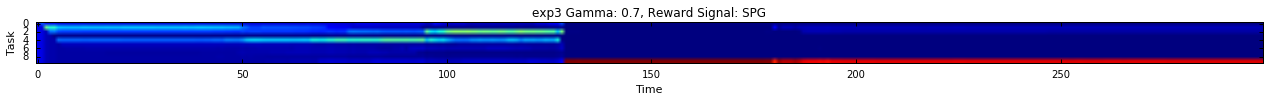

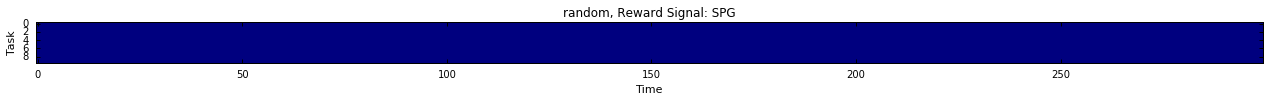

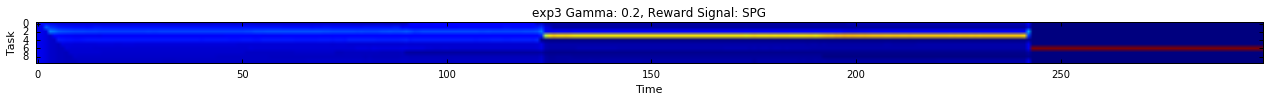

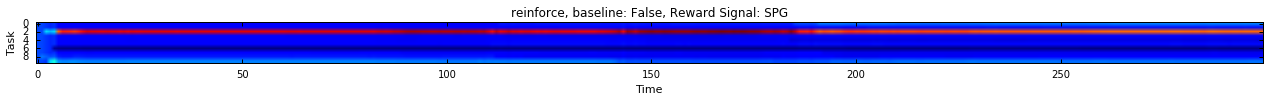

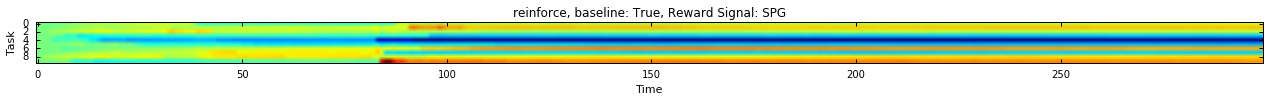

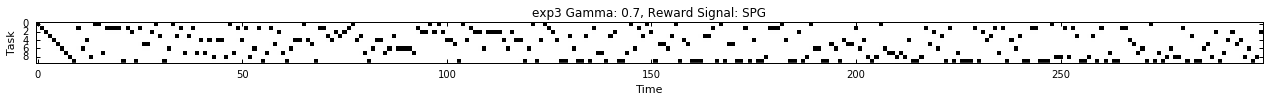

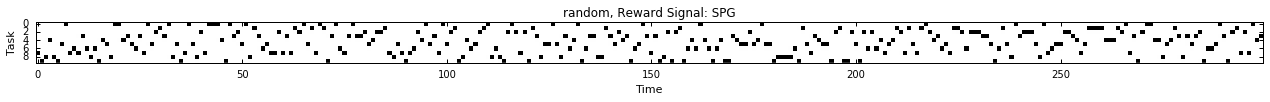

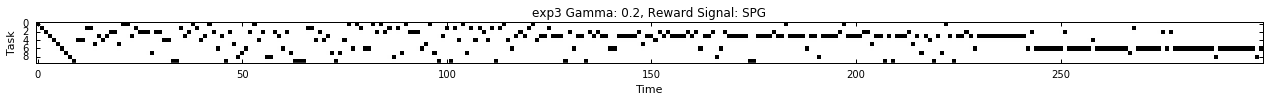

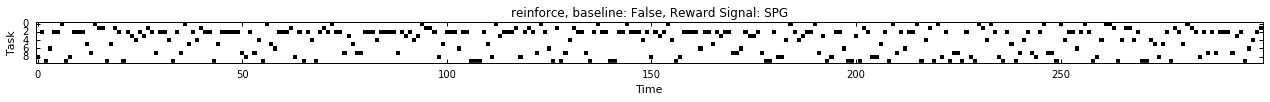

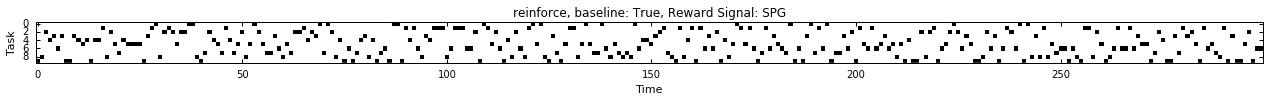

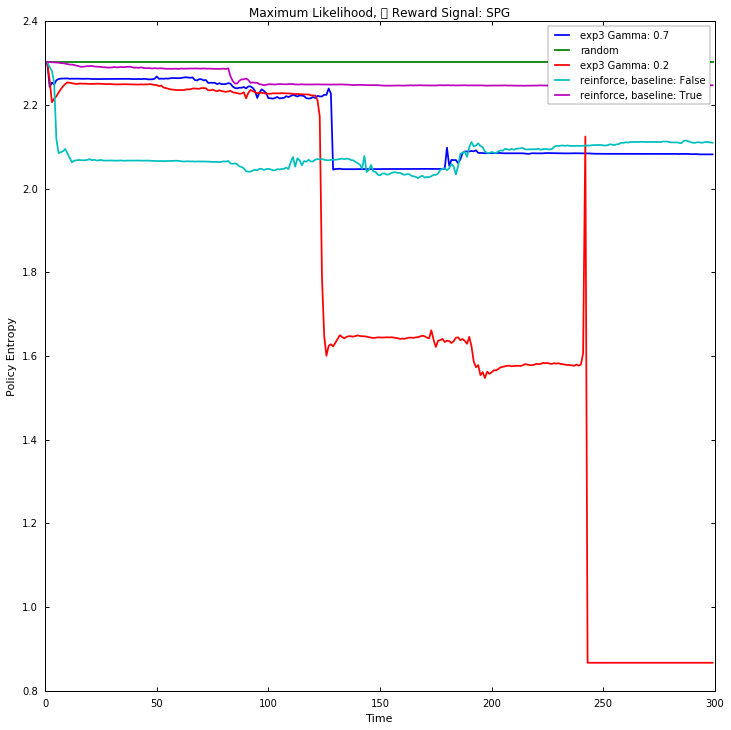

In [108]:
# Intrinsically Motivated Curriculum Learning

number_of_arms = len(split_train_tasks)
number_of_steps = 300

agents = [
     Random(number_of_arms),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
     EXP3(number_of_arms, 0.2),
     EXP3(number_of_arms, 0.7),
#     EXP3S(number_of_arms, 0.2, 0.01),
#     EXP3S(number_of_arms, 0.2, 0.1),
#     EXP3S(number_of_arms, 0.2, 0.2),
#     EXP3S(number_of_arms, 0.7, 0.01),
#     EXP3S(number_of_arms, 0.7, 0.1),
#     EXP3S(number_of_arms, 0.7, 0.2),
     REINFORCE(number_of_arms),
     REINFORCE(number_of_arms, baseline=True),
]

train_task_agents(agents, number_of_arms, number_of_steps, 'SPG')

  